In [1]:
import numpy as np
import skimage.io as skio
import skimage.util as sku

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)

In [3]:
import skimage.segmentation as seg

In [4]:
from skimage.future import graph
import skimage.filters as skf
import skimage.color as skc

In [5]:
from sklearn.neighbors import LocalOutlierFactor as LOF

In [6]:
def normalize_graph(g):
    values = []
    for _, _, d in g.edges(data=True):
        values.append(d["weight"])
    values = np.sort(values)
    
    # outlier smoothing
    outliers = LOF().fit_predict(values[:, None])
    values =  values[outliers > 0]
    min_val, max_val = values.min(), values.max() - values.min()
    
    for _, _, d in g.edges(data=True):
        weight = d["weight"]
        
        if weight > max_val: 
            weight = max_val
        if weight < min_val:
            weight = min_val
        weight = (weight - min_val) / max_val
        
        d["weight"] = weight
    
    return g

In [7]:
def hufbauer_alpha(image, labels, connectivity=2, fudge=1e-8):
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'pixel count': 0,
                            'total color': np.array([0, 0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        rag.node[current]['pixel count'] += 1
        rag.node[current]['total color'] += image[index]

    for n in rag:
        rag.node[n]['mean color'] = (rag.node[n]['total color'] /
                                     rag.node[n]['pixel count'])
        rag.node[n]['alpha'] = np.sum(rag.node[n]['mean color'] ** 2)

    for x, y, d in rag.edges(data=True):
        #d['weight'] = 1 / (fudge + (rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2)
        d['weight'] = (rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2.
        #d['weight'] = np.log((rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2.)

    return rag

In [8]:
def hufbauer_beta(image, labels, connectivity=2):
    image = skc.rgb2lab(image)[:, :, [1,2]]
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'pixel count': 0,
                            'total hue': np.array([0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        rag.node[current]['pixel count'] += 1
        rag.node[current]['total hue'] += image[index]

    for n in rag:
        rag.node[n]['mean hue'] = (rag.node[n]['total hue'] /
                                     rag.node[n]['pixel count'])

    for x, y, d in rag.edges(data=True):
        diff = rag.node[x]['mean hue'] - rag.node[y]['mean hue']
        diff = np.linalg.norm(diff)
        d['weight'] = diff

    return rag

In [9]:
from sklearn.metrics import adjusted_rand_score

In [10]:
import networkx as nx

In [11]:
def segment_proposals(img, sps, horizon):
    num_sps = sps.max() + 1
    
    rag_a = normalize_graph(hufbauer_alpha(img, sps))
    rag_b = normalize_graph(hufbauer_beta(img, sps))
    
    adj_a = nx.adjacency_matrix(rag_a).todense()
    adj_b = nx.adjacency_matrix(rag_b).todense()

    adj = np.c_[
        np.r_[
            adj_a, 
            np.diag(np.ones(num_sps)),
        ],
        np.r_[
            np.diag(np.ones(num_sps)),
            adj_b,
        ],
    ]
    
    #steps = list(sim_to_horizon(adj, horizon))

    starts = np.c_["c", np.diag(np.ones(num_sps)), np.diag(np.ones(num_sps))]
    
    # likelyhood that superpixel N is reached within |steps| when starting from s.p. M
#     reached_on_step = np.array([
#         starts * step
#         for step in steps
#     ])
#     reached = reached_on_step.sum(axis=0)
    reached = starts * adj**horizon
    #reached = (reached[:, :num_sps] + reached[:, num_sps:]) # keep?

    reached = np.array(reached)
    reached -= reached.min()
    reached /= reached.max()
    
    return reached.T

In [17]:
def merge_proposals(proposals, sps, thresh):
    masks = (proposals[sps] < thresh).astype(int)
    
    base = np.zeros_like(masks[:,:,0])
    for mask in np.rollaxis(masks, 2):
        base = seg.join_segmentations(base, mask)
    return base

In [19]:
def method(img, horizon=100, thresh=0.05):
    sps = seg.slic(img, slic_zero=True)
    prop = segment_proposals(img, sps, horizon)
    return merge_proposals(prop, sps, thresh)

/u/amo-d0/ugrad/connor/software/anaconda/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):


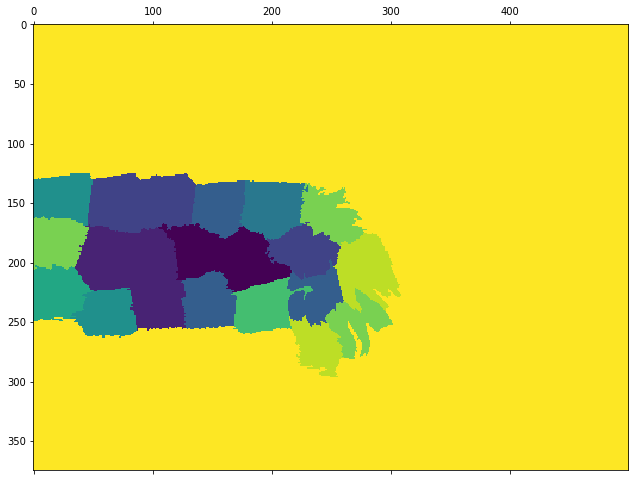

In [20]:
img = sku.img_as_float(skio.imread("moto.jpg"))
plt.matshow(method(img))

In [15]:
import dataset

In [21]:
imgs, anno = dataset.make_dataset(limit=100)

In [22]:
scores = []
for img, ann in zip(imgs, anno):
    pred = method(img)
    scores.append(adjusted_rand_score(ann.flat, pred.flat))

/u/amo-d0/ugrad/connor/software/anaconda/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):


In [23]:
scores

[0.34474928556483464,
 0.20754444013687057,
 -0.021006703351484426,
 0.19490898864431194,
 -0.104107302826631,
 0.017818555378531532,
 0.21386329034837434,
 0.16121150645183324,
 0.25337091143885565,
 0.4603985895035455,
 0.3476461996710562,
 0.17045279576531866,
 0.2780024019631124,
 0.20976018739226424,
 0.09038310866669073,
 0.06027380689955908,
 -0.07101464481770901,
 0.09145271545789577,
 -0.030099056642993883,
 0.28520844000917944,
 0.146086031707912,
 0.22946795249266153,
 0.5510161543409856,
 0.1496364795160651,
 0.2559926680859587,
 0.2572595837049413,
 0.02914045145013879,
 0.3948636732541448,
 0.4022268834455048,
 0.1961923569787751,
 0.097539934866438,
 -0.12839596762103833,
 -0.08905418658050691,
 0.12149117267934173,
 0.3109093855085996,
 -0.014571423547300457,
 0.4253803688685134,
 0.22732409048450583,
 0.313758259025933,
 0.03980096236427963,
 0.225845500440459,
 -0.10138275401219131,
 -0.011518760273738554,
 0.04365349037752731,
 0.3025168853323487,
 -0.142991349006140

In [32]:
best_ours = np.argsort(scores)[::-1][:5]
best_ours

array([46, 22,  9, 36, 57])

/u/amo-d0/ugrad/connor/software/anaconda/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):


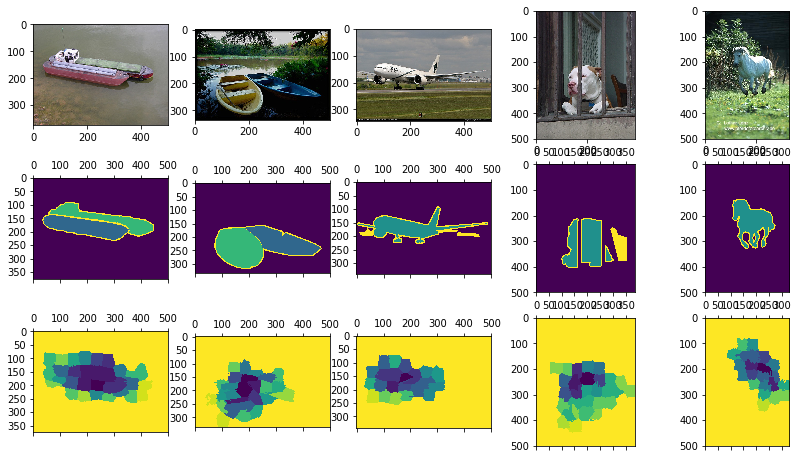

In [33]:
_, axs = plt.subplots(3,5)
for idx, ax in zip(best_ours, axs.T):
    img = imgs[idx]
    ann = anno[idx]
    
    pred = method(img)
    score = adjusted_rand_score(ann.flat, pred.flat)
    
    ax[0].imshow(img)
    ax[1].matshow(ann)
    ax[2].matshow(pred)

In [24]:
np.mean(scores)

0.15100537280126944

In [25]:
from sklearn.cluster import KMeans
def baseline(img):
    sps = seg.slic(img, slic_zero=True)
    M = np.stack([
        img[sps == i].mean(axis=0)
        for i in np.unique(sps)
    ])
    clusts = KMeans(4).fit_predict(M)
    return clusts[sps]

In [26]:
baseline_scores = []
for img, ann in zip(imgs, anno):
    pred = baseline(img)
    baseline_scores.append(adjusted_rand_score(ann.flat, pred.flat))

In [27]:
baseline_scores

[-0.001782882155864338,
 0.024241301876928047,
 0.13717198996619148,
 0.03496594582958601,
 0.168575599338725,
 0.10716471413977052,
 0.07642203350409557,
 0.02031072296863537,
 0.34626585815244,
 0.10024263092991098,
 -1.5333772277537823e-06,
 0.11537905581325457,
 0.10545469222063525,
 0.024137927348738382,
 0.2896312128113345,
 0.03323384570749134,
 0.027901939114723162,
 0.13644575579635498,
 0.011336894097046909,
 -0.024860527917967185,
 0.29239753463439905,
 0.07613285894151843,
 0.05185650525244759,
 0.006089334066460322,
 0.27540903955989704,
 0.055833805693687975,
 0.04374131008446082,
 0.0031293963905467278,
 0.07668575079085824,
 0.21738158309895558,
 0.024112147504596667,
 -0.0030578626358702533,
 0.08035219177074382,
 0.031124612976565692,
 -0.0003675236559194249,
 0.2627145030455236,
 0.1061563721539763,
 0.05980977386316525,
 0.04393387565260528,
 0.2503858515136325,
 0.01596886650376266,
 0.18749262605681813,
 -0.00051980415749736,
 0.03948639726831448,
 0.1686591690627

In [34]:
best_base = np.argsort(baseline_scores)[::-1][:5]
best_base

array([52, 90, 73, 49,  8])

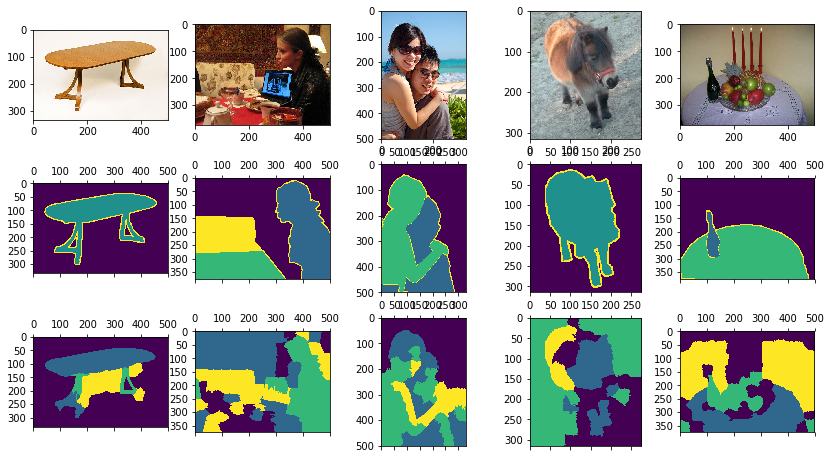

In [35]:
_, axs = plt.subplots(3,5)
for idx, ax in zip(best_base, axs.T):
    img = imgs[idx]
    ann = anno[idx]
    
    pred = baseline(img)
    score = adjusted_rand_score(ann.flat, pred.flat)
    
    ax[0].imshow(img)
    ax[1].matshow(ann)
    ax[2].matshow(pred)

In [28]:
np.mean(baseline_scores)

0.12343620016327568

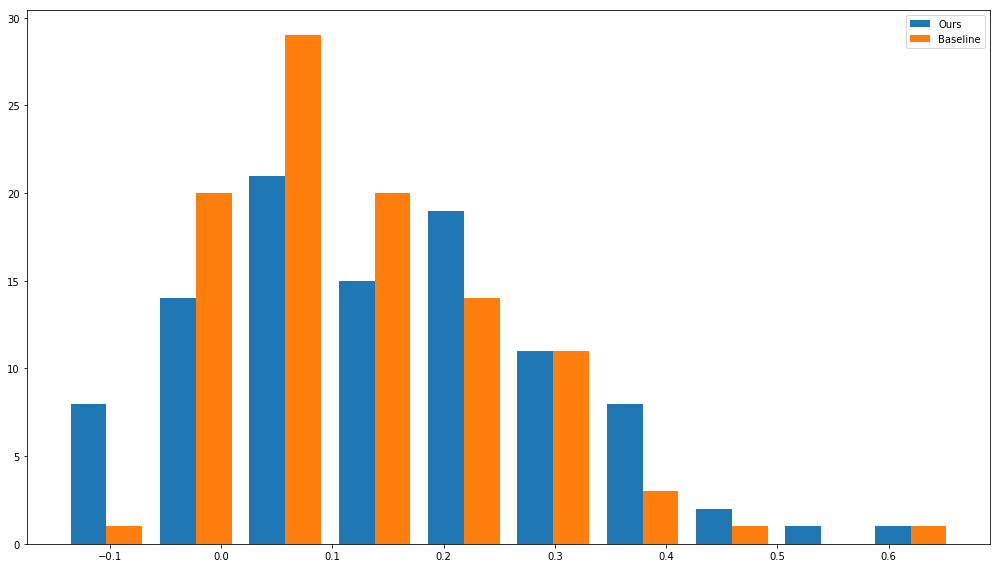

In [29]:
plt.hist([scores, baseline_scores], label=["Ours", "Baseline"])
plt.legend()
plt.tight_layout()